Using device: cuda
Found 7 car classes: ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']
Train images: 3352
Test images:  813


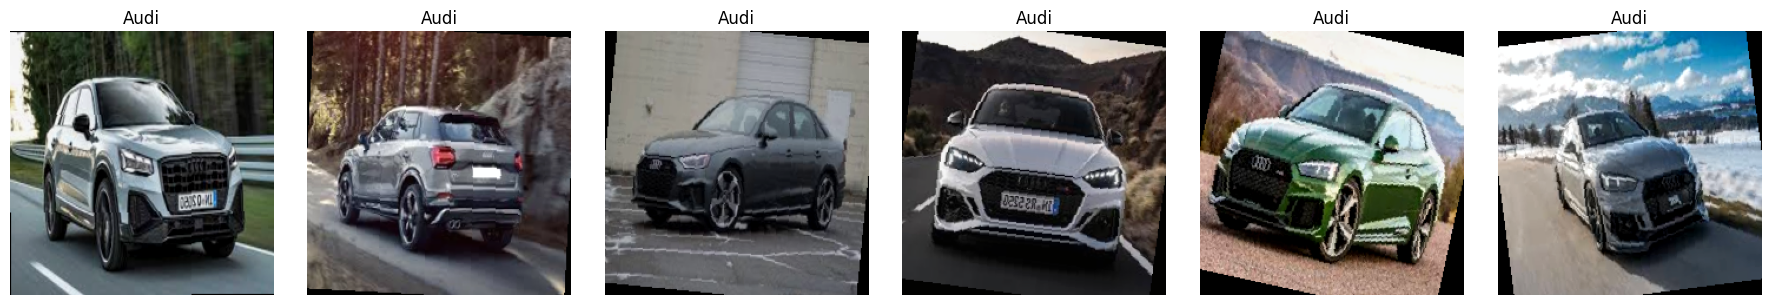

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=4096, out_features=7, bias=True)
  )
)
Epoch [1/20] Loss: 1.2788 | Train Acc: 54.27% | Test Acc: 70.36%
Epoch [2/20] Loss: 0.9976 | Train Acc: 64.86% | Test Acc: 77.00%
Epoch [3/20] Loss: 0.9348 | Train Acc: 67.12% | Test Acc: 76.14%
Epoch [4/20] Loss: 0.8991 | Train Acc: 68.62% | Test Acc: 77.00%
Epoch [5/20] Loss: 0.8911 | Train Acc: 68.94% | Test Acc: 78.72%
Epoch [6/20] Loss: 0.8933 | Train Acc: 68.88% | Test Acc: 79.34%
Epoch [7/20] Loss: 0.8830 | Train Acc: 69.48% | Test Acc: 77.61%
Epoch [8/20] Loss: 0.8983 | Train Acc: 70.50% | Test Acc: 78.11%
Epoch [9/20] Loss: 0.9195 | Train Acc: 69.12% | Test Acc: 79.83%
Epoch [10/20] Loss: 0.9174 

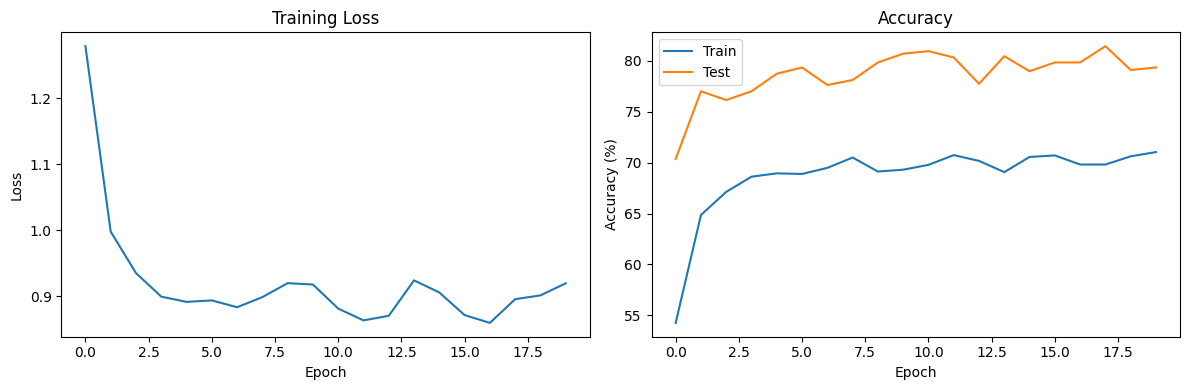

Model saved to car_classifier.pth


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
TRAIN_DIR = "/kaggle/input/cars-image-dataset/Cars Dataset/train"
TEST_DIR = "/kaggle/input/cars-image-dataset/Cars Dataset/test"
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
#data augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)

print(f"Found {num_classes} car classes: {class_names}")
print(f"Train images: {len(train_dataset)}")
print(f"Test images:  {len(test_dataset)}")
fig, axes = plt.subplots(1, 6, figsize=(18, 3))
for i, (img, label) in enumerate(train_dataset):
    if i >= 6:
        break
    img_display = img.permute(1, 2, 0).numpy()
    img_display = img_display * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_display = img_display.clip(0, 1)
    axes[i].imshow(img_display)
    axes[i].set_title(class_names[label])
    axes[i].axis("off")
plt.tight_layout()
plt.show()
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Replace final classifier block (unfrozen by default)
model.classifier[6] = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(4096, num_classes)
)

model = model.to(DEVICE)
print(model.classifier)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=LEARNING_RATE)

train_losses = []
train_accs = []
test_accs = []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Evaluate on test set
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_acc = 100.0 * test_correct / test_total
    test_accs.append(test_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Loss: {epoch_loss:.4f} | "
          f"Train Acc: {epoch_acc:.2f}% | "
          f"Test Acc: {test_acc:.2f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses)
ax1.set_title("Training Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

ax2.plot(train_accs, label="Train")
ax2.plot(test_accs, label="Test")
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.legend()

plt.tight_layout()
plt.show()

#  Save Model
torch.save({
    "model_state_dict": model.state_dict(),
    "class_names": class_names,
    "num_classes": num_classes,
}, "car_classifier.pth")

print("Model saved to car_classifier.pth")

# - Predict on a Single Image
from PIL import Image

def predict(image_path):
    """Predict the car class for a single image."""
    img = Image.open(image_path).convert("RGB")
    img_tensor = test_transform(img).unsqueeze(0).to(DEVICE)

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        confidence, predicted = probs.max(1)

    label = class_names[predicted.item()]
    conf = confidence.item() * 100
    print(f"Prediction: {label} ({conf:.1f}%)")

    plt.imshow(Image.open(image_path))
    plt.title(f"{label} ({conf:.1f}%)")
    plt.axis("off")
    plt.show()
    return label, conf